In [1]:
# Build dataset loader

import numpy as np
from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

# load data (modify to match your data directory or comment)
def load_sports_data():
  drive.mount('/content/drive')
  datadir = "/content/drive/MyDrive/CS441_Final_Project/" # modify this to your directory
  df_sports = pd.read_csv(datadir + 'sports_events.csv') # loads raw CSV into pandas dataframe

  # tokenization: creates col where event names converted into list of tokens
  df_sports['event_tokens'] = df_sports["event_name"].apply(lambda x: x.split('_'))
  # puts unique words from from event tokens list into set
  all_words = set(word for tokens in df_sports['event_tokens'] for word in tokens)

  # creates padding token (to fill short sequences)
  PAD_TOKEN = '<PAD>'
  # creates unknown token (to handle new words not in training vocab, necessary for zero-shot prediction)
  UNK_TOKEN = '<UNK>'
  # sets padding token to have ID 0 and unknown token to have ID 1
  word2id = {PAD_TOKEN: 0, UNK_TOKEN: 1}

  # map all other unique words to IDs starting from 2 (since 0 and 1 alr used)
  start_index = len(word2id)
  word2id.update({w: i + start_index for i, w in enumerate(sorted(list(all_words)))})

  # assigns unique ID # to every sport
  sport2id = {s:i for i,s in enumerate(df_sports["sport"].unique())}
  # assigns unique ID # to every category / label
  label2id = {c:i for i,c in enumerate(df_sports["category"].unique())}

  # convert list of word tokens into list of of corresponding ID # (mapped to unknown token ID 1 if not found)
  x_event_words = df_sports['event_tokens'].apply(lambda tokens:
      [word2id.get(w, word2id[UNK_TOKEN]) for w in tokens]).tolist()

  # covert sport names into into list of corresponding ID #
  x_sport = df_sports["sport"].map(sport2id).values
  # covert category names into into list of corresponding ID #
  y = df_sports["category"].map(label2id).values

  return (df_sports, x_event_words, x_sport, y, word2id, sport2id, label2id)

In [2]:
from torch.nn.utils.rnn import pad_sequence

# custom function for PyTorch DataLoader to add padding to sequences since it can't handle sequences of different lengths
# 'batch' is a list of tuples: (word_ids_list, sport_id, label)
def collate_fn_pad(batch):
  # unpacks the batch list of tuples into three separate lists
  event_sequences, sport_ids, labels = zip(*batch)
  # PyTorch pad_sequence function pads all the sequences in event_sequences with ID 0 so each has the same length
  event_sequences_padded = pad_sequence([torch.as_tensor(seq, dtype=torch.long) for seq in event_sequences],
                                        batch_first=True, padding_value=0)
  # combines the lists of sport ids into a single list (no padding needed)
  sport_ids = torch.stack(sport_ids)
  # combines the lists of label ids into a single list (no padding needed)
  labels = torch.stack(labels)
  # returns three processed tensors
  return event_sequences_padded, sport_ids, labels

In [3]:
from sklearn.model_selection import train_test_split

# calls dataset loader function to load and process dataset
df_sports, x_event_words, x_sport, y, word2id, sport2id, label2id = load_sports_data()
# creates array of integers from 0 to total number of samples in csv file
indices = np.arange(len(x_sport))

# split data into train, test, and val sets

# splits indices into 80% train/val set and 20% test set (stratify w/ y to ensure proprtion of categories in test same as dataset)
idx_train_full, idx_test = train_test_split(indices, test_size=0.2, random_state=0, stratify=y)
# splits indices into 60%(0.75*80) train set and 20%(0.25*80) test set
idx_train, idx_val = train_test_split(idx_train_full, test_size=0.25, random_state=0, stratify=y[idx_train_full])

# helper fn extracts word IDs, sports IDs, and category IDs data at the given indices
def get_subset(indices):
    return ([x_event_words[i] for i in indices], x_sport[indices], y[indices])

# call get_subset helper fn on train, test, and val sets
x_word_train, x_sport_train, y_train = get_subset(idx_train)
x_word_val, x_sport_val, y_val = get_subset(idx_val)
x_word_test, x_sport_test, y_test = get_subset(idx_test)

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# custom function wraps train, test, and val sets in DataSet object for PyTorch (couldn't just use TensorDataset bc of word lists)
class SportsSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, x_word, x_sport, y):
        self.x_word = x_word
        self.x_sport = torch.tensor(x_sport, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): # retuns total number of samples in word dataset
        return len(self.x_word)
    def __getitem__(self, idx): # returns features & label (word, sport, and y) tensors for that idx
        return (torch.tensor(self.x_word[idx], dtype=torch.long),
                self.x_sport[idx],
                self.y[idx])

# instantiates three sperate datasets for training, testing, and validation
train_dataset = SportsSequenceDataset(x_word_train, x_sport_train, y_train)
test_dataset = SportsSequenceDataset(x_word_test, x_sport_test, y_test)
val_dataset = SportsSequenceDataset(x_word_val, x_sport_val, y_val)

# instantiates three sperate DataLoader objects for training, testing, and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn_pad)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn_pad)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn_pad)

# calculates size of words, sports, and category classes
num_words = len(word2id)
num_sports = len(sport2id)
num_classes = len(label2id)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# add weighted averaging (tf-idf weighting)

# helper function to split event names by _
def underscore_tokenizer(text):
    return text.split('_')

# creates list of all words excluding padding and unknown
word_list_no_special = sorted([w for w, i in word2id.items() if i > 1])
# gets list of all events from dataframe
event_names_list = df_sports["event_name"].tolist()

'''
tfidf vector model = tool in NLP converting text into numerical vectors
that weights common words lower and rare words higher
'''
# configures and fits tdidf vectorizer model
tfidf_model = TfidfVectorizer(
    tokenizer=underscore_tokenizer,
    vocabulary=word_list_no_special,
    use_idf=True,
    smooth_idf=True
)
tfidf_model.fit(event_names_list)

# creates idf weights array and initializes all values to 1
idf_weights = np.ones(num_words, dtype=np.float32)
# gets idf scores from fitted tfidf model
idf_scores = tfidf_model.idf_

# loops through tfidf model vocabulary
for word, index in tfidf_model.vocabulary_.items():
    # finds unique ID # my model uses for that word
    global_index = word2id[word]
    # sets the idf_score into the right position in the idf weights array
    idf_weights[global_index] = idf_scores[index]

# converts idf weights array into a tensor
idf_weights_tensor = torch.tensor(idf_weights, dtype=torch.float32)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
'''
----------------------------------
Model # 1 = Multi-Layer Perceptron
----------------------------------
'''

# defines MLP model with:
# word embedding layer = learns semantic vector (embedding) for every word
# sport embedding layer = learns distinct vector rep for each sport
# storing of idf weights inside model (to not be trained or optimized)
# MLP classifier w/ linear layer, ReLU layer, dropout layer (for regularization), and final linear layer
# forward function =
# - look up word vector for every word ID in input seq
# - look up idf weight for every for word ID
# - multiply word vector by idf scalar weight (apply weights)
# - final event vector = sum of weighted vectors / sum of weights
# - look up sport vector for sport ID
# - concatenates event vector & sport vector side by side to fed to MLP classifier
class EventEmbeddingMLP(nn.Module):
    def __init__(self, num_words, num_sports, idf_weights_tensor, word_embedding_dim=64, sport_embedding_dim=16, num_classes=5):
        super(EventEmbeddingMLP, self).__init__()
        self.word_emb = nn.Embedding(num_words, word_embedding_dim, padding_idx=0)
        self.sport_emb = nn.Embedding(num_sports, sport_embedding_dim)

        self.register_buffer('idf_weights', idf_weights_tensor)
        total_input_dim = word_embedding_dim + sport_embedding_dim
        self.mlp = torch.nn.Sequential(
          torch.nn.Linear(total_input_dim, 64),
          torch.nn.ReLU(),
          torch.nn.Dropout(p=0.5),
          torch.nn.Linear(64, num_classes)
       )

    def forward(self, word_id_sequences, sport_ids):
        word_vec = self.word_emb(word_id_sequences)
        weights = self.idf_weights[word_id_sequences]
        weighted_word_vec = word_vec * weights.unsqueeze(-1)

        sum_of_weighted_vectors = weighted_word_vec.sum(dim=1)
        sum_of_weights = weights.sum(dim=1, keepdim=True) + 1e-6
        event_vec = sum_of_weighted_vectors / sum_of_weights

        sport_vec = self.sport_emb(sport_ids)
        x = torch.cat([event_vec, sport_vec], dim=1)
        return self.mlp(x)

# evaluate MLP model
def evaluate_MLP_sports(model, loader, device):
  model.eval() # sets model to evaluation mode
  total, correct, total_loss = 0, 0, 0
  loss_function = torch.nn.CrossEntropyLoss()
  with torch.no_grad():
    for word_sequences, sport_ids, labels in loader:
      word_sequences, sport_ids, labels = word_sequences.to(device), sport_ids.to(device), labels.to(device)
      # runs forward pass on batch to generate predictions
      outputs = model(word_sequences, sport_ids)
      loss = loss_function(outputs, labels)
      total_loss += loss.item() * labels.size(0)
      # determines final predicted category
      preds = outputs.argmax(dim=1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)
  # computes the average loss and accuracy
  avg_loss = total_loss / total
  acc = correct / total
  return avg_loss, acc

# train MLP model
def train_MLP_sports(model, train_loader, test_loader, val_loader, lr=0.001, num_epochs=100, weight_decay=1e-3, device='cpu'):
  model.to(device)
  # sets loss function
  loss_function = nn.CrossEntropyLoss()
  # initializes adam optimizer to update weights to minimize loss with weight decay for L2 regularization
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  # initializes learning rate scheduler that reduces lr if val_acc plateaus
  scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)

  train_losses, test_losses, val_losses = [], [],  []
  train_accuracies, test_accuracies, val_accuracies = [], [], []

  best_train_acc = 0.0
  best_test_acc = 0.0
  best_val_acc = 0.0
  best_epoch = 0
  best_model_state = None

  # main training loop that iterates over dataset many times to refine weights
  for epoch in range(0, num_epochs):
    model.train()
    for event_ids, sport_ids, labels in train_loader:
      event_ids, sport_ids, labels = event_ids.to(device), sport_ids.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(event_ids, sport_ids)
      loss = loss_function(outputs, labels)
      # backpropagation to calculates gradients and update model weights
      loss.backward()
      optimizer.step()

    t_loss, t_acc = evaluate_MLP_sports(model, train_loader, device)
    ts_loss, ts_acc = evaluate_MLP_sports(model, test_loader, device)
    v_loss, v_acc = evaluate_MLP_sports(model, val_loader, device)

    train_losses.append(t_loss)
    train_accuracies.append(t_acc)

    test_losses.append(ts_loss)
    test_accuracies.append(ts_acc)

    val_losses.append(v_loss)
    val_accuracies.append(v_acc)

    # tells the scheduler the val accuracy for curr epoch
    scheduler.step(v_acc)
    # tracks highest val accuracy and saves weights for it
    if v_acc > best_val_acc:
        best_train_acc = t_acc
        best_test_acc = ts_acc
        best_val_acc = v_acc
        best_epoch = epoch
        best_model_state = model.state_dict()

  if best_model_state is not None:
      model.load_state_dict(best_model_state)

  return model, best_train_acc, best_test_acc, best_val_acc

In [7]:
# prepare data for logistic regression and linear svm models model

# converts event ID sequences into feature vectors suitable for LR/SVM with the word IDs, sport IDs, and MLP's learned embedding weights
def create_lr_svm_features(word_id_sequences, sport_ids, word_emb_matrix):
    avg_vectors = []
    for sequence in word_id_sequences:
        valid_indices = [idx for idx in sequence if idx != 0]
        if valid_indices:
            vectors = word_emb_matrix[valid_indices]
            avg_vec = np.mean(vectors, axis=0)
        else:
            avg_vec = np.zeros(word_emb_matrix.shape[1])
        avg_vectors.append(avg_vec)
    X_word_avg = np.array(avg_vectors)
    X_features = np.hstack([X_word_avg, sport_ids.reshape(-1, 1)])
    return X_features

# generates feature matrices for train, test, and val sets for LR/SVM
def create_lr_svm_data_sets(model, x_word_train, x_word_test, x_word_val, x_sport_train, x_sport_test, x_sport_val):
    word_emb_weights = model.word_emb.weight.data.cpu().numpy()
    x_train_lr = create_lr_svm_features(x_word_train, x_sport_train, word_emb_weights)
    x_val_lr = create_lr_svm_features(x_word_val, x_sport_val, word_emb_weights)
    x_test_lr = create_lr_svm_features(x_word_test, x_sport_test, word_emb_weights)
    return x_train_lr, x_test_lr, x_val_lr

In [8]:
'''
---------------------------------
 Model # 2 = Logistic Regression
---------------------------------
'''
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# logistic regresion model = probabilistic classification
# trains, fits, and predicts using logistic regression model
def train_log_reg_sports(model, x_word_train, x_word_test, x_word_val, x_sport_train, x_sport_test, x_sport_val):
    log_reg = LogisticRegression(max_iter=1000, random_state=0)
    x_train_lr, x_test_lr, x_val_lr = create_lr_svm_data_sets(model, x_word_train, x_word_test, x_word_val, x_sport_train, x_sport_test, x_sport_val)
    # train
    log_reg.fit(x_train_lr, y_train)
    # predict
    y_train_pred = log_reg.predict(x_train_lr)
    y_val_pred = log_reg.predict(x_val_lr)
    y_test_pred = log_reg.predict(x_test_lr)
    # return accuracies
    return accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred), accuracy_score(y_val, y_val_pred)

In [9]:
'''
--------------------------------
 Model # 3 = Linear SVM
--------------------------------
'''
from sklearn.svm import LinearSVC

# linear svm model = margin-based classification
# trains, fits, and predicts using linear svm model
def train_lin_svm_sports(model, x_word_train, x_word_test, x_word_val, x_sport_train, x_sport_test, x_sport_val):
    svm_clf = LinearSVC(C=1.0, max_iter=5000, dual='auto', random_state=42)
    x_train_lr, x_test_lr, x_val_lr = create_lr_svm_data_sets(model, x_word_train, x_word_test, x_word_val, x_sport_train, x_sport_test, x_sport_val)
    # train
    svm_clf.fit(x_train_lr, y_train)
    # predict
    y_train_pred = svm_clf.predict(x_train_lr)
    y_val_pred = svm_clf.predict(x_val_lr)
    y_test_pred = svm_clf.predict(x_test_lr)
    # accuracies
    return accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred), accuracy_score(y_val, y_val_pred)

In [10]:
'''
-------------------
 Models Comparison
-------------------
'''
import random
# repeat training and evaluation process multiple times to get better performance report
num_trials = 10
# tracks MLP's best val accuracy
best_overall_val_acc = 0.0
# stores MLP's state at best val accuracy
best_mlp_state = None
mlp_test_accuracies = []
lr_test_accuracies = []
svm_test_accuracies = []

for trial in range(num_trials):
    print(f"\n--- Starting Trial {trial + 1}/{num_trials} ---")
    # sets unique seed for reproducibility
    seed = 42 + trial
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # ------------------------------------------------------------
    # TRAIN & EVAL MLP MODEL (to learn embeddings for this trial)
    # ------------------------------------------------------------

    model = EventEmbeddingMLP(num_words=num_words, num_sports=num_sports,
                              idf_weights_tensor=idf_weights_tensor,
                              word_embedding_dim=16, sport_embedding_dim=16,
                              num_classes=num_classes)

    model, mlp_train_acc, mlp_test_acc, mlp_val_acc = train_MLP_sports(
        model, train_loader, test_loader, val_loader, lr=0.005, num_epochs=100, weight_decay=5e-3, device='cpu')
    mlp_test_accuracies.append(mlp_test_acc)

    # check for the best overall MLP model based on validation acc
    if mlp_val_acc > best_overall_val_acc:
        best_overall_val_acc = mlp_val_acc
        best_mlp_state = model.state_dict()
        print(f"**New Best MLP Model:** Trial {trial + 1} with Val Acc: {best_overall_val_acc:.3f}")

    # ----------------------
    # TRAIN & EVAL LR MODEL
    # ----------------------
    lr_train_acc, lr_test_acc, lr_val_acc = train_log_reg_sports(model, x_word_train, x_word_test, x_word_val, x_sport_train, x_sport_test, x_sport_val)
    lr_test_accuracies.append(lr_test_acc)

    # ------------------------------
    # TRAIN & EVAL LINEAR SVM MODEL
    # ------------------------------
    svm_train_acc, svm_test_acc, svm_val_acc = train_lin_svm_sports(model, x_word_train, x_word_test, x_word_val, x_sport_train, x_sport_test, x_sport_val)
    svm_test_accuracies.append(svm_test_acc)

    # print test accuracies for all models for curr trial
    print(f"Trial {trial + 1} Test Accuracies: MLP={mlp_test_acc:.3f}, LR={lr_test_acc:.3f}, SVM={svm_test_acc:.3f}")

# helper function to print out avg test accuracies & best single run test accuracy for models
def report_stats(accuracies, model_name):
    avg_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    print(f"{model_name} Final Report (N={num_trials} Trials):")
    print(f"Average Test Accuracy: {avg_acc:.4f} +/- {std_acc:.4f}")
    print(f"Best Single Run Test Accuracy: {max(accuracies):.4f}\n")

print("\n==============================================")
report_stats(mlp_test_accuracies, "MLP")
report_stats(lr_test_accuracies, "Logistic Regression")
report_stats(svm_test_accuracies, "Linear SVM")
print("==============================================")

# load the best MLP weights for final visualization/use
if best_mlp_state:
    print(f"Loading the best MLP weights (from Trial with Val Acc: {best_overall_val_acc:.3f}).")
    model.load_state_dict(best_mlp_state)



--- Starting Trial 1/10 ---
**New Best MLP Model:** Trial 1 with Val Acc: 0.516
Trial 1 Test Accuracies: MLP=0.569, LR=0.545, SVM=0.557

--- Starting Trial 2/10 ---
Trial 2 Test Accuracies: MLP=0.504, LR=0.520, SVM=0.541

--- Starting Trial 3/10 ---
Trial 3 Test Accuracies: MLP=0.512, LR=0.504, SVM=0.508

--- Starting Trial 4/10 ---
Trial 4 Test Accuracies: MLP=0.516, LR=0.533, SVM=0.545

--- Starting Trial 5/10 ---
Trial 5 Test Accuracies: MLP=0.573, LR=0.557, SVM=0.545

--- Starting Trial 6/10 ---
Trial 6 Test Accuracies: MLP=0.492, LR=0.504, SVM=0.504

--- Starting Trial 7/10 ---
Trial 7 Test Accuracies: MLP=0.512, LR=0.520, SVM=0.549

--- Starting Trial 8/10 ---
Trial 8 Test Accuracies: MLP=0.520, LR=0.528, SVM=0.533

--- Starting Trial 9/10 ---
Trial 9 Test Accuracies: MLP=0.533, LR=0.520, SVM=0.524

--- Starting Trial 10/10 ---
Trial 10 Test Accuracies: MLP=0.472, LR=0.472, SVM=0.492

MLP Final Report (N=10 Trials):
Average Test Accuracy: 0.5203 +/- 0.0299
Best Single Run Test A

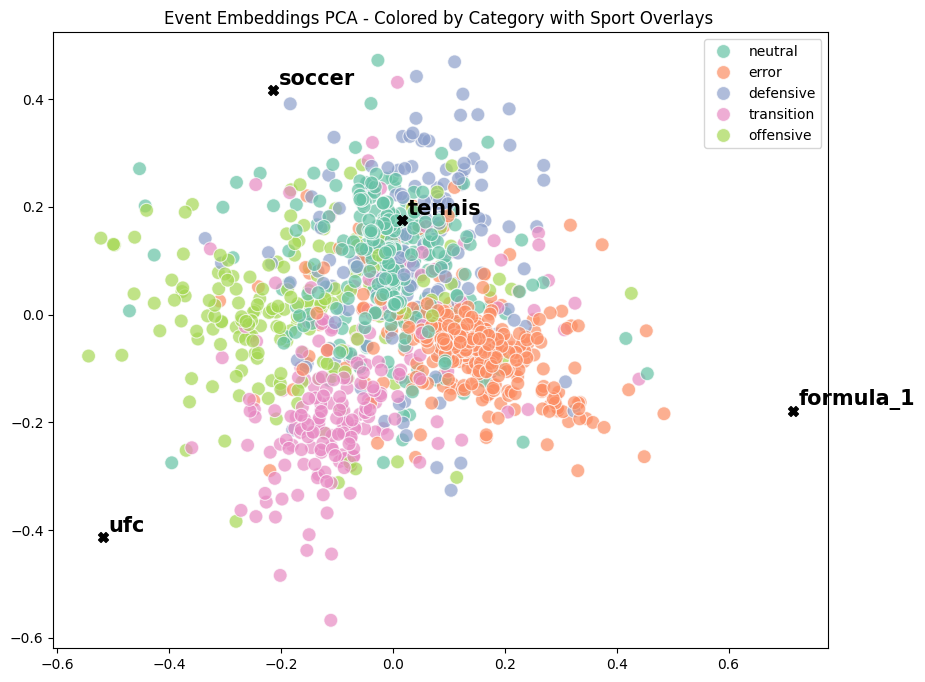

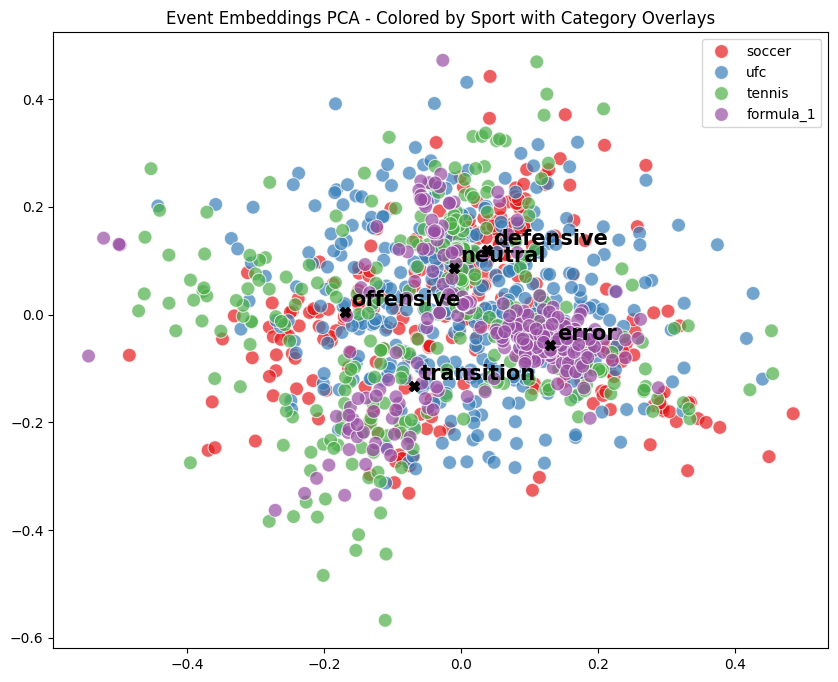

In [11]:
from sklearn.decomposition import PCA
'''
--------------------------------------------------------------------------------
 PCA Embeddings Display w/ MLP (Highest Poential/Best Single Run Test Accuracy)
--------------------------------------------------------------------------------
'''
# extract final learned word embeddings from best performing MLP model
word_embeddings = model.word_emb.weight.detach().cpu().numpy()
# extract final learned sports embeddings from best performing MLP model
sport_embeddings = model.sport_emb.weight.detach().cpu().numpy()
word2id_map = word2id
# gets the static idf weights tensor
idf_weights_tensor = model.idf_weights.cpu()
# gets a list of every unqiue event and name in dataset
unique_event_names = df_sports["event_name"].unique()

event_embeddings_list = []
event_categories = []
event_sports = []

# loops through all unique events to create final feature vector
for event_name in unique_event_names:
    # converts event name back into ID #
    tokens = event_name.split('_')
    token_ids = [word2id_map.get(t, word2id_map['<UNK>']) for t in tokens]
    token_ids_tensor = torch.tensor(token_ids, dtype=torch.long)
    # looks up word vectors for event
    word_vec = model.word_emb(token_ids_tensor)
    # looks up idf weights for event & reshapes to match vector dim
    weights = idf_weights_tensor[token_ids_tensor].unsqueeze(-1)
    # multiplies word vectors by their idf weights
    weighted_word_vec = word_vec * weights
    # calculates final idf weighted average event vector
    sum_of_weighted_vectors = weighted_word_vec.sum(dim=0)
    sum_of_weights = weights.sum(dim=0) + 1e-6
    event_vec = (sum_of_weighted_vectors / sum_of_weights).detach().cpu().numpy()
    # builds final matrix of features for PCA analysis
    event_embeddings_list.append(event_vec)
    # looks up true category and sport for that event
    row = df_sports[df_sports['event_name'] == event_name].iloc[0]
    # gets sport and labels to be used to color PCA plot
    event_categories.append(label2id[row['category']])
    event_sports.append(sport2id[row['sport']])

# prepares input matrix for PCA
event_embeddings_final = np.array(event_embeddings_list)
event_categories = np.array(event_categories)
event_sports = np.array(event_sports)

id2label = {v:k for k,v in label2id.items()}
id2sport = {v:k for k,v in sport2id.items()}
category_names_final = np.array([id2label[i] for i in event_categories])
sport_names_final = np.array([id2sport[i] for i in event_sports])


# configures pca tool to find two directions of greatest variance in data
pca = PCA(n_components=2)
# executes pca algorithm on event embedding and sports embedding
event_2d = pca.fit_transform(event_embeddings_final)
sport_2d = pca.fit_transform(sport_embeddings)


# PCA plot clusters events colored by category & shows relationship to sports vector
plt.figure(figsize=(10,8))
sns.scatterplot(x=event_2d[:,0], y=event_2d[:,1], hue=category_names_final, palette="Set2", s=100, alpha=0.7)
plt.scatter(sport_2d[:,0], sport_2d[:,1], color='black', s=50, marker='X', label='Sports')
for i, name in id2sport.items():
    plt.text(sport_2d[i,0]+0.01, sport_2d[i,1]+0.01, name, fontsize=15, fontweight='bold')
plt.title("Event Embeddings PCA - Colored by Category with Sport Overlays ")
plt.show()

# finds the center of each category cluster
category_centroids = np.zeros((len(label2id), 2))
for label_id in range(len(label2id)):
    inds = np.where(event_categories == label_id)[0]
    category_centroids[label_id] = event_2d[inds].mean(axis=0)

# PCA plot clusters events colored by sport & shows relationship to category vector
plt.figure(figsize=(10,8))
sns.scatterplot(x=event_2d[:,0], y=event_2d[:,1], hue=sport_names_final, palette="Set1", s=100, alpha=0.7)
plt.scatter(category_centroids[:,0], category_centroids[:,1], color='black', s=50, marker='X', label='Categories')
for i, name in id2label.items():
    plt.text(category_centroids[i,0]+0.01, category_centroids[i,1]+0.01, name, fontsize=15, fontweight='bold')
plt.title("Event Embeddings PCA - Colored by Sport with Category Overlays")
plt.show()

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
'''
------------------------------------------------------------------------------------
 Nearest-Neighbors Analysis w/ MLP (Highest Poential/Best Single Run Test Accuracy)
------------------------------------------------------------------------------------
'''

# extracts learn sport embedding vector from best MLP model
sport_embeddings = model.sport_emb.weight.detach().cpu().numpy()
id2sport = {v:k for k,v in sport2id.items()}

# use KNN to find closest sports to given sport
def find_nearest_sport_neighbors(query_sport, top_k=3):
    if query_sport not in sport2id:
        return f"Sport '{query_sport}' not found in vocabulary."
    # gets ID # for given sport
    query_id = sport2id[query_sport]
    # gets learned sport vector for given sport
    query_vector = sport_embeddings[query_id]
    # calculates cosine similarity between given sport & all other sport vectors
    similarities = cosine_similarity(query_vector.reshape(1, -1), sport_embeddings)
    # sorts and filters for the top 3 cloeset neighbors
    nearest_indices = np.argsort(similarities[0])[-top_k-1:-1][::-1]
    # prints out the given sport's nearest neighbors
    print(f"\n--- Nearest Sports for: '{query_sport}' ---")
    results = []
    for rank, index in enumerate(nearest_indices):
        neighbor_sport = id2sport[index]
        score = similarities[0][index]
        results.append(f"  {rank + 1}. {neighbor_sport} (Similarity: {score:.4f})")
    return "\n".join(results)

# execute KNN analysis for each sport in our dataset
query_sports = ["soccer", "tennis", "ufc", "formula_1"]
for sport in query_sports:
    print(find_nearest_sport_neighbors(sport))


--- Nearest Sports for: 'soccer' ---
  1. tennis (Similarity: 0.3243)
  2. formula_1 (Similarity: -0.1331)
  3. ufc (Similarity: -0.6621)

--- Nearest Sports for: 'tennis' ---
  1. formula_1 (Similarity: 0.4189)
  2. soccer (Similarity: 0.3243)
  3. ufc (Similarity: -0.8206)

--- Nearest Sports for: 'ufc' ---
  1. formula_1 (Similarity: -0.5287)
  2. soccer (Similarity: -0.6621)
  3. tennis (Similarity: -0.8206)

--- Nearest Sports for: 'formula_1' ---
  1. tennis (Similarity: 0.4189)
  2. soccer (Similarity: -0.1331)
  3. ufc (Similarity: -0.5287)


In [13]:
'''
----------------------------------------------------------------------------------------------
 Predict Category for New Sport Event w/ MLP (Highest Poential/Best Single Run Test Accuracy)
----------------------------------------------------------------------------------------------
'''
# zero-shot classification = model categorizes data into classes not seein in training
# defines zero-shot function that returns category given new event name
def predict_zero_shot_category(event_name, sport_name="unknown"):
    if not event_name:
      return "Please enter an event name."

    # tokenizes new event name
    tokens = event_name.lower().split('_')
    # converts words into ID #s f
    token_ids = [word2id.get(t, word2id['<UNK>']) for t in tokens]
    # converts seq of IDs into tensor for model
    token_ids_tensor = torch.tensor([token_ids], dtype=torch.long)
    # feed placeholder into sport vector bc unknown
    sport_id_tensor = torch.tensor([0], dtype=torch.long)

    with torch.no_grad():
        # predicts using MLP model
        output = model(token_ids_tensor, sport_id_tensor)
        # finds prediction idx with highest prob score
        predicted_index = torch.argmax(output, dim=1).item()
    # converts predicted idx # back into category name
    id2label = {v:k for k,v in label2id.items()}
    predicted_category = id2label[predicted_index]
    # returns predicted category
    return predicted_category.upper()

# test cases
category_basketball = predict_zero_shot_category("traveling_call", sport_name="basketball")
category_football = predict_zero_shot_category("interception", sport_name="football")
category_hockey = predict_zero_shot_category("outlet_pass", sport_name="hockey")
category_volleyball = predict_zero_shot_category("spike", sport_name="volleyball")

print(f"\nPrediction for 'traveling_call' (Basketball): {category_basketball}")
print(f"\nPrediction for 'interception' (Football): {category_football}")
print(f"\nPrediction for 'outlet_pass' (Hockey): {category_hockey}")
print(f"\nPrediction for 'spike' (Volleyball): {category_volleyball}")


Prediction for 'traveling_call' (Basketball): ERROR

Prediction for 'interception' (Football): DEFENSIVE

Prediction for 'outlet_pass' (Hockey): TRANSITION

Prediction for 'spike' (Volleyball): OFFENSIVE


In [14]:
!pip install gradio -q

In [15]:
'''
--------------------
 Model Application
--------------------
'''
# showcase gradio application
import gradio as gr
# create gradio interface
iface = gr.Interface(
    fn=predict_zero_shot_category,
    inputs=gr.Textbox(
        lines=1,
        placeholder="e.g., 'home_run', 'power_play'",
        label="Enter Unfamiliar Event Name (underscore separated)"
    ),
    outputs=gr.Label(label="Predicted Category"),
    title="Zero-Shot Sport Event Categorization Demo",
    description="This demonstrates the model's ability to classify events from new sports (outside training data) based on semantic meaning."
)

# launches app with temp link
print("=== Launching Gradio Web App... ===")
iface.launch(share=True)

=== Launching Gradio Web App... ===
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e8f5f4b07585329a7a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
